# Generative Modeling 

Generative modeling is a type of unsupervised learning that seeks to generate a model that learns characteristics of a sample dataset.  

# Autoencoders 

Autoencoders are a type of neural network that are used to learn data encodings in an unsupervised manner.  During training, the input and output of autoencoders are (ideally) identical.  The network itself has a bow-tie shape.  


![arch](images/autoencoder-architecture.png)

The `z` vector at the bottleneck of the autoencoder is the latent reprsentation of the input data.  It is usually in a compressed, low dimensional form.  

Autoencoders are good for density estimation, but not generating new sample data.  That is, if we feed a random set of numbers into the decoder, it is not likely to produce a good generated sample.  Variational autoencoders (VAE) help with this problem.   

# Variational autoencoders (VAE) 

Variational autoencoders replace the bottleneck in traditional autoencoders with a sampling step.  Instead of predicting the latent vector, `z`, directly, we instead attempt to estimate the distribution of the `z` vector.  That is, we estimate its mean and standard deviation.  Vectors that are passed into the decoder are sampled.  


![vae](images/vae.webp)
---
---
---


# Example using MNIST

In [1]:
import time 
import os 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import PIL
from IPython import display


## Prepare data  

### Load Data
Note that we don't care about the image labels because generative modeling is an unsupervised learning task.

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

### Data preprocessing

In [3]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)


In [4]:
train_size = 60000
batch_size = 32
test_size = 10000


In [5]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))


## Design Models

### Define architecture

In [6]:
LATENT_DIM = 2

In [7]:
encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Flatten(),
        # No activation
        tf.keras.layers.Dense(LATENT_DIM + LATENT_DIM) 
        ])


In [8]:
decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(LATENT_DIM,)),
        tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',
            activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same',
            activation='relu'),
        # No activation
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
        ])


In [9]:
@tf.function
def sample(epsilon=None):
    """ Forward pass through second half of network.  Used for generating data samples.    
        Sample epsilon using tensorflow utilities 
    """
    if epsilon is None:
        epsilon = tf.random.normal(shape=(100, LATENT_DIM))
    return decode(epsilon, apply_sigmoid=True)



def encode(X): 
    """ Forward pass of encoder network 
    
        Input is data vector, X.  
    """
    mean, logvar = tf.split(encoder(X), num_or_size_splits=2, axis=1)
    return mean, logvar 


def reparameterize(mean, logvar):
    """ Forward pass through bottleneck section of network.  Outputs z vector.  
    """
    epsilon = tf.random.normal(shape=mean.shape)
    return epsilon * tf.exp(logvar * .5) + mean




def decode(z, apply_sigmoid=False): 
    """ Forward pass of decoder network.  
    
        Input is a sampled z vector 
    """
    logits = decoder(z) 
    
    if apply_sigmoid: 
        probs = tf.sigmoid(logits)
        return probs 
    return logits 
    

### Define losses and optimizer

The VAE will be optimizing over the [evidence lower bound (ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound) on the marginal log-likelihood. 

In [10]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    """ Utility for ELBO.
    """
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(x): 
    """ Calculates model loss 
    """
    # Forward pass through the network 
    mean, logvar = encode(x)
    z = reparameterize(mean, logvar)
    x_logit = decode(z)
    
    # Calculate reconstruction loss (binary cross entropy)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    
    # Calculate regularization portion (ELBO) 
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    

#### Training step 

In [11]:
@tf.function
def train_step(x, optimizer):
    """Executes one training step and returns the loss.  

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    
    # Use GradientTape to record a computation graph 
    with tf.GradientTape() as tape:
        loss = compute_loss(x)
        
    # The tape is used to compute gradients using the computation graph 
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))


## Training 

In [12]:
epochs = 10
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, LATENT_DIM])

Define plotting utilities.

In [13]:
def generate_and_save_images(epoch, test_sample):
    """ Utility for saving image during training epoch   
    """
    mean, logvar = encode(test_sample)
    z = reparameterize(mean, logvar)
    # Use the sample function to generate a new sample z vector 
    predictions = sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [14]:
# Set aside a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]


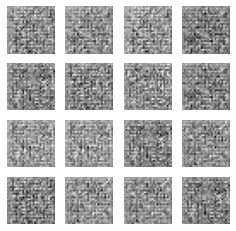

In [15]:
generate_and_save_images(0, test_sample)

### Run training loop

Epoch: 10, time elapse for current epoch: 4.4082112312316895


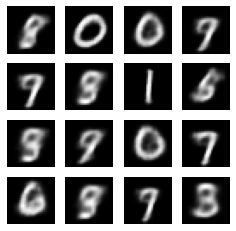

In [16]:
for epoch in range(1, epochs + 1):
    
    # tic
    start_time = time.time()
    
    for train_x in train_dataset: 
        train_step(train_x, optimizer)

    # toc 
    end_time = time.time()

    display.clear_output(wait=False)
    print('Epoch: {}, time elapse for current epoch: {}'
        .format(epoch, end_time - start_time))
    generate_and_save_images(epoch, test_sample)


What we're seeing above are random `z` vectors being tossed into the decoder during training.  This helps us understand if its actually learning the latent space well.  

## Visualize the latent space 

Note, you may need to install `tensorflow_probability` to run this code 

```sh
conda install -c conda-forge tensorflow-probability
```

In [19]:
import tensorflow_probability as tfp

def plot_latent_images(n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='viridis')
    plt.axis('Off')
    plt.show()

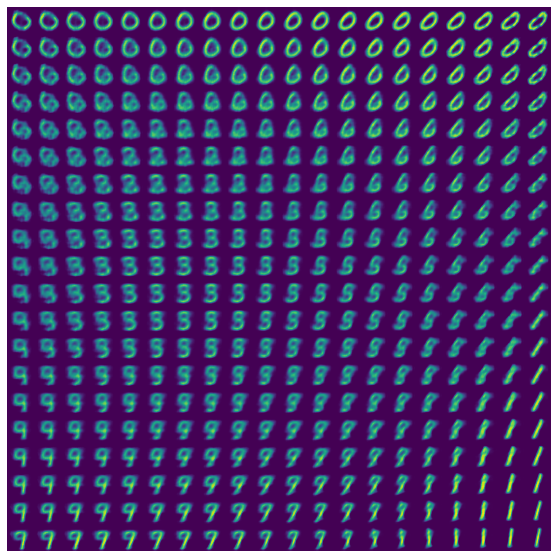

In [20]:
plot_latent_images(20)

# References 
+ https://en.wikipedia.org/wiki/Autoencoder 
+ https://www.tensorflow.org/tutorials/generative/cvae
+ https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/
